# 1. Warming-up

The idea of this assignment is to familiarise yourself with a pretrained network on ImageNet performing object recognition.

We first import all necessary packages.

In [2]:
import numpy as np

import torch
from torchvision import transforms, models
from PIL import Image

import cv2
import skimage
from matplotlib import pyplot as plt

import requests
from io import BytesIO

## ResNet
We will particularly look at ResNet, but similar analaysis could be conducted for other networks.

By calling ```weights=models.ResNet50_Weights.IMAGENET1K_V2``` we obtain the weights of the network pretrained on ImageNet.

We move the model to evaluation model to ensur weights are not updated.

In [10]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We can look at the parameters of the model by calling the

In [21]:
for name, param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

## Loading an image

We download one image with a URl and show its content. Please note that by default PyTorch expects PIL images, but the corresponding functions can be written in numpy as well.

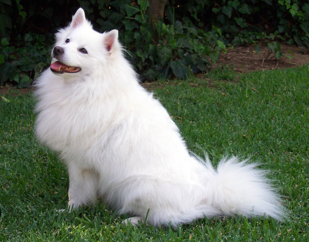

In [4]:
# Download an example image from the pytorch website
url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"

# Openning the image and visualising it
input_image = Image.open(requests.get(url, stream=True).raw)
input_image.resize((input_image.width // 5, input_image.height // 5))

## Transforming the image to tensor.

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [15]:
# sample execution (requires torchvision)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [16]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

## Executing the model

In evaluation model we always call the ```with torch.no_grad()``` to tell to the framework not to compute gradients, the graph is very heavy and in test time we don't use it.

In [17]:
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print("Output size", output.shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print("Probabilites size", probabilities.shape)

Output size torch.Size([1, 1000])
Probabilites size torch.Size([1000])


## Assesing the output

In [19]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-04-20 09:31:27--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0s      

2023-04-20 09:31:27 (25,2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [20]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.455370157957077
white wolf 0.03246971592307091
Pomeranian 0.02825578674674034
Great Pyrenees 0.009267075918614864
Eskimo dog 0.007829354144632816


## Assignment 

Please do the following questions and submit it by **Thursday, April 27 at 23h59 O'clock**.
The submission is a **notebook (.ipynb)** it can include code, comments, written texts, and plots.

### 1. Plot all the kernels of the first layer.
You can access the wights of the first layer from the parameters ```conv1.weight``` whose size is ```torch.Size([64, 3, 7, 7])```.
Therefore the visualisation should include 64 kernels of size 7x7 in colour.

### 2. Change ```input_batch``` to load 4 different images.
Run the model with all 4 images at the same time, print the obtained classes for each image.

### 3. Add noise to the first layer.
Add some sort of noise (e.g., from Gaussian or Poisson distribution) to the weights of the first layer (i.e., either, ```conv1.weight```  or ```conv1.bias``` ). How sensitive is the network to such noise.

### 4. Add noise to input image.
Add some sort of noise (e.g., from Gaussian or Poisson distribution) the input images. How sensitive is the network to such noise.